In [1]:
import keras
import datetime
import tensorflow                       as tf
from tensorflow.keras.callbacks         import TensorBoard
from tensorflow.keras.layers            import Input, Lambda, Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,concatenate,BatchNormalization, Activation
from tensorflow.keras.models            import Model
from tensorflow.keras.optimizers        import Adam
from keras.utils                        import plot_model
from tensorflow.keras                   import layers, models
from tensorflow.keras.losses            import mae
import sys
import os
import numpy as np
import math
import random, time

import skimage                      as ski
from   skimage.filters              import threshold_otsu
from   skimage                      import io, color
from   skimage.color                import rgb2gray
from   skimage                      import filters
import cv2                          as cv
import matplotlib.pyplot            as plt

2025-04-23 16:01:10.256362: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 16:01:10.258702: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 16:01:10.265952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745438470.278696    3667 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745438470.282409    3667 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745438470.291771    3667 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [41]:
import tensorflow as tf

print("Is GPU available:", tf.config.list_logical_devices('GPU'))

# More detailed info
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Is GPU available: []
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9980406762439985492
xla_global_id: -1
]


E0000 00:00:1745442147.444038    3667 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1745442147.444649    3667 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### 1. Load Directory 

In [2]:
# Files path
#directory= os.path.abspath("/home/guiomar/Desktop/CODES/DLCODES")
directory= os.path.abspath("/home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5")
# Add directory to sys.path
sys.path.append(directory)

# import script where hiperparameters are defined
import param  

# Set the number of cores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
num_threads = param.n_threads  
tf.config.threading.set_intra_op_parallelism_threads(num_threads)


### 2. Define Parameters

In [4]:
#Load the main directory
paths=param.list_paths 
for i,j in enumerate(paths):
    print(f'{i} => {j}')
    
# Defining amount of train,valid,test images   
n_train=param.n_train;    n_valid=param.n_valid;    n_test=param.n_test

# Defining a sample i.e.
n_sample=param.n_sample

#Pack them into batches (we’ll use batches of 10 images e.g.)
BATCH_SIZE=param.pack_size  

# For resizing dimentions
h=param.img_height
w=param.img_width

print(f'\nTrain = {n_train},Test = {n_test}, Valid = {n_valid}\n')
print(f'Dimensions resized h = {h}, w = {w}\n')
print(f'Pack into {BATCH_SIZE} images')

0 => /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/Geometry
1 => /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/Magnitude
2 => /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/Pression
3 => /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/U001
4 => /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/U002

Train = 0.7,Test = 0.2, Valid = 0.1

Dimensions resized h = 128, w = 256

Pack into 10 images


### 3. Processing images

In [1]:
# method for reading image    
def get_img(img_name):
    return ski.io.imread(img_name)

In [5]:
# method for reading image    
def get_img(img_name):
    return ski.io.imread(img_name)
 
# method for turning to a grey or binary image 
def processing(image,option=True):
        x = get_img(image)  
        x = rgb2gray(x)       # It returns a grayscale image with floating point values in the range from 0 to 1
        x =cv.resize(x,(w,h)) # Reshape image 
    
        # Binary option otherwise gray
        if (option):
            x=ski.util.img_as_ubyte(x)  # Convert it back to the original data type and the data range back 0 to 255. 
                                        # It is often better to use image values represented by floating point values 
            best_value_threshold=np.round(filters.threshold_otsu(x)) #  Otsu’s method calculates an “optimal” threshold
            #_,x= cv.threshold(x, best_value_threshold, 255, cv.THRESH_BINARY_INV)
            _,x= cv.threshold(x, best_value_threshold, 255, cv.THRESH_BINARY)
            x=x/255.

        x=x[:, :, np.newaxis]
        return x
    
# method for splitting data
def split_data(path,n_sample,n_train,n_valid,n_test):
        
        files=sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".png")])
        n_files=len(files)
        if(n_files>n_sample):
                print('Loaded ',n_sample,'/',n_files,'**** from ',path,'\n')
                if (n_train + n_valid + n_test == 1.0):
        
                    n_train= math.floor(n_sample*n_train)
                    n_valid = math.floor(n_sample*n_valid) + n_train
                    n_test = math.floor(n_sample*n_test) + n_valid
              
                    (files_train,files_valid,files_tests) = (files[0:n_train], files[n_train:n_valid],files[n_valid:n_test])
                    
                return files_train,files_valid,files_tests

def arrays_img_processed(data,type=True): # True for Geometry 
    # begin in data[1:] 
    if type:
        list_arrays=[processing(image,option=True).astype(np.float32) for image in data[1:] ]
    else:
        list_arrays=[processing(image,option=False).astype(np.float32) for image in data[1:] ]
   
    return np.array(list_arrays) 


In [14]:
# Geometry
geo_train,geo_valid,geo_tests=split_data(paths[0],n_sample,n_train,n_valid,n_test)
geo_array_train=arrays_img_processed(geo_train)
geo_array_valid=arrays_img_processed(geo_valid)
geo_array_tests=arrays_img_processed(geo_tests)

# Magnitude
specific_tarjet=paths[1]
mag_train,mag_valid,mag_tests=split_data(specific_tarjet,n_sample,n_train,n_valid,n_test)
mag_array_train=arrays_img_processed(mag_train,False)
mag_array_valid=arrays_img_processed(mag_valid,False)
mag_array_tests=arrays_img_processed(mag_tests,False)


# Pression
specific_tarjet=paths[2]
p_train,p_valid,p_tests=split_data(specific_tarjet,n_sample,n_train,n_valid,n_test)
p_array_train=arrays_img_processed(p_train,False)
p_array_valid=arrays_img_processed(p_valid,False)
p_array_tests=arrays_img_processed(p_tests,False)


# Vx
specific_tarjet=paths[3]
vx_train,vx_valid,vx_tests=split_data(specific_tarjet,n_sample,n_train,n_valid,n_test)
vx_array_train=arrays_img_processed(vx_train,False)
vx_array_valid=arrays_img_processed(vx_valid,False)
vx_array_tests=arrays_img_processed(vx_tests,False)

# Vy
specific_tarjet=paths[4]
vy_train,vy_valid,vy_tests=split_data(specific_tarjet,n_sample,n_train,n_valid,n_test)
vy_array_train=arrays_img_processed(vy_train,False)
vy_array_valid=arrays_img_processed(vy_valid,False)
vy_array_tests=arrays_img_processed(vy_tests,False)


print(f'Training data for geometry: {geo_array_train.shape}')
print(f'Training data for magnitude: {mag_array_train.shape}\n')
print(f'Valid data for geometry: {geo_array_valid.shape}')
print(f'Valid data for magnitude: {mag_array_valid.shape}\n')
print(f'Test data for geometry: {geo_array_tests.shape}')
print(f'Test data for magnitude: {mag_array_tests.shape}\n')
print(f'Training data for pression: {p_array_train.shape}')
print(f'Training data for vx: {vx_array_train.shape}')
print(f'Training data for vy: {vy_array_train.shape}')



print(f'geo[3][100][200] = {geo_array_train[3][100][200]}')
print(f'mag[3][100][200] = {mag_array_train[3][100][200]}')

Loaded  150 / 20001 **** from  /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/Geometry 

Loaded  150 / 20001 **** from  /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/Magnitude 

Loaded  150 / 20001 **** from  /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/Pression 

Loaded  150 / 20001 **** from  /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/U001 

Loaded  150 / 20001 **** from  /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/U002 

Training data for geometry: (104, 128, 256, 1)
Training data for magnitude: (104, 128, 256, 1)

Valid data for geometry: (14, 128, 256, 1)
Valid data for magnitude: (14, 128, 256, 1)

Test data for geometry: (29, 128, 256, 1)
Test data for magnitude: (29, 128, 256, 1)

Training data for pression: (104, 128, 256, 1)
Training data for vx: (104, 128, 256, 1)
Training data for vy: (104, 128, 256, 1)
geo[3][100][200] = [1.]
mag[3][100][200] = [0.16917804]


0.29803923

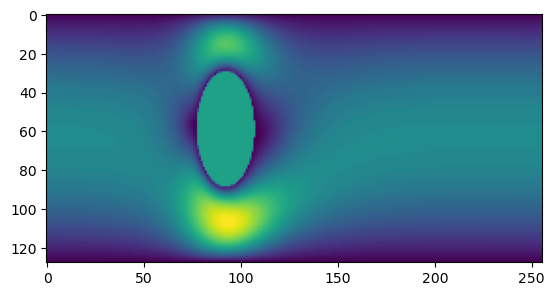

In [55]:
plt.imshow(mag_array_train[0,:,:,0])
mag_array_train[0,61,91,0]

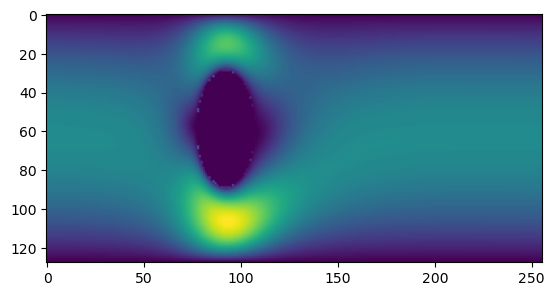

In [59]:
temp = geo_array_train[0] * mag_array_train[0]
plt.imshow(temp)

In [38]:
merged_train = np.concatenate((mag_array_train, p_array_train, vx_array_train, vy_array_train), axis=-1)
print(merged_train.shape)

merged_tests = np.concatenate((mag_array_tests, p_array_tests, vx_array_tests, vy_array_tests), axis=-1)
print(merged_tests.shape)

(104, 128, 256, 4)
(29, 128, 256, 4)


In [39]:
train_data=tf.data.Dataset.from_tensor_slices((geo_array_train, merged_train))
tests_data=tf.data.Dataset.from_tensor_slices((geo_array_tests, merged_tests))

In [26]:
# Dataset Objects
# slices of an array in the form of objects by using tf.data.Dataset.from_tensor_slices() method
#train_data=tf.data.Dataset.from_tensor_slices((geo_array_train, mag_array_train))
#valid_data=tf.data.Dataset.from_tensor_slices((geo_array_valid, mag_array_valid))

#representing the number of consecutive elements of this dataset to combine in a single batch
#the last batch is dropped in the case it has fewer than batch_size elements

#trainLoader = train_data.batch(BATCH_SIZE,drop_remainder=True)
#valiLoader = valid_data.batch(BATCH_SIZE,drop_remainder=True)

trainLoader = train_data.batch(BATCH_SIZE,drop_remainder=True)
testsLoader = tests_data.batch(BATCH_SIZE,drop_remainder=True)

print("Training & validation batches number: {} , {}\n".format(len(trainLoader),len(testsLoader) ))
i=0
for geo_batch, mag_batch,p,vx,vy in trainLoader:
    print("geo batch shape:", geo_batch.shape)
    print("mag batch shape:", mag_batch.shape)
    print("p batch shape:", p.shape)
    print("vx batch shape:", vx.shape)
    print("vy batch shape:", vy.shape)
    i=i+1
    print(f'batch number {i}')
    print('------------------')
    break



'''
i=0;
for geo_batch, mag_batch in trainLoader:
    print("geo batch shape:", geo_batch.shape)
    print("mag batch shape:", mag_batch.shape)
    i=i+1
    print(f'batch number {i}')
    print('------------------')
    break
'''    

Training & validation batches number: 10 , 2

geo batch shape: (10, 128, 256, 1)
mag batch shape: (10, 128, 256, 1)
p batch shape: (10, 128, 256, 1)
vx batch shape: (10, 128, 256, 1)
vy batch shape: (10, 128, 256, 1)
batch number 1
------------------


'\ni=0;\nfor geo_batch, mag_batch in trainLoader:\n    print("geo batch shape:", geo_batch.shape)\n    print("mag batch shape:", mag_batch.shape)\n    i=i+1\n    print(f\'batch number {i}\')\n    print(\'------------------\')\n    break\n'

### 4. Show data

In [22]:
def plot(a1,a2,title=None,opt=None):
    if opt==None:
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
        ax1.set_xticks([]); ax1.set_yticks([]);
        ax2.set_xticks([]); ax2.set_yticks([]);
        ax1.imshow(a1,origin='upper',cmap='gray')
        ax1.set_title('Input',fontsize=14)
        #ax1.set_xlabel('Geometry')
        ax1.set_ylabel('Geometry',fontsize=14)
        ax2.imshow(a2,origin='upper',cmap='gray')
        ax2.set_title('Target output',fontsize=14)
        #ax2.set_xlabel('u')
        ax2.set_ylabel('u',fontsize=16)
        if title is not None: fig.suptitle(title)
    else:
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
        ax1.set_xticks([]); ax1.set_yticks([]);
        ax2.set_xticks([]); ax2.set_yticks([]);
        ax1.imshow(a1,origin='upper',cmap='gray')
        ax1.set_title('Real',fontsize=14)
        #ax1.set_xlabel('Geometry')
        ax1.set_ylabel('u',fontsize=14)
        ax2.imshow(a2,origin='upper',cmap='gray')
        ax2.set_title('Prediction',fontsize=14)
        #ax2.set_xlabel('u')
        ax2.set_ylabel('u',fontsize=16)
        if title is not None: fig.suptitle(title)
        

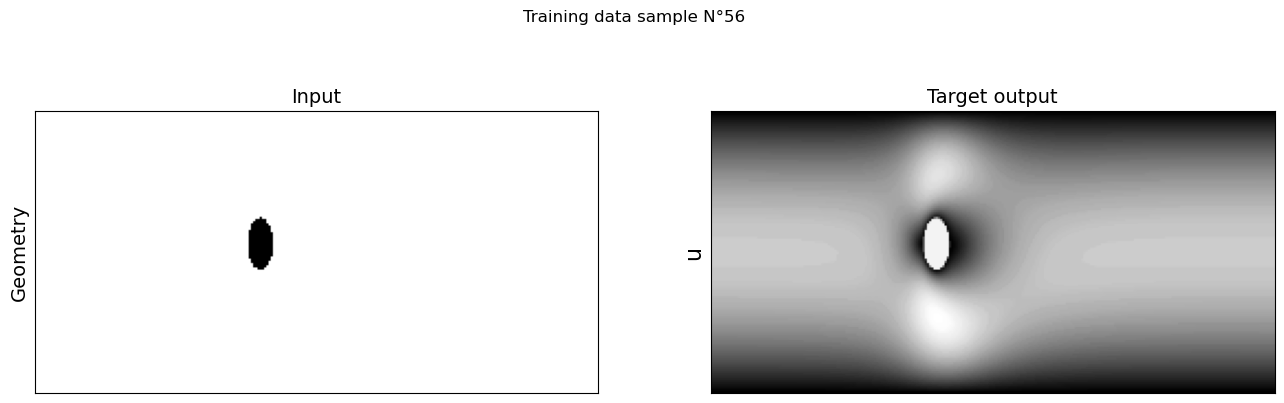

In [8]:
NUM=random.sample(range(1, geo_array_train.shape[0]), 1)
plot( geo_array_train[NUM[0]],mag_array_train[NUM[0]], title=f"Training data sample N°{NUM[0]}") 

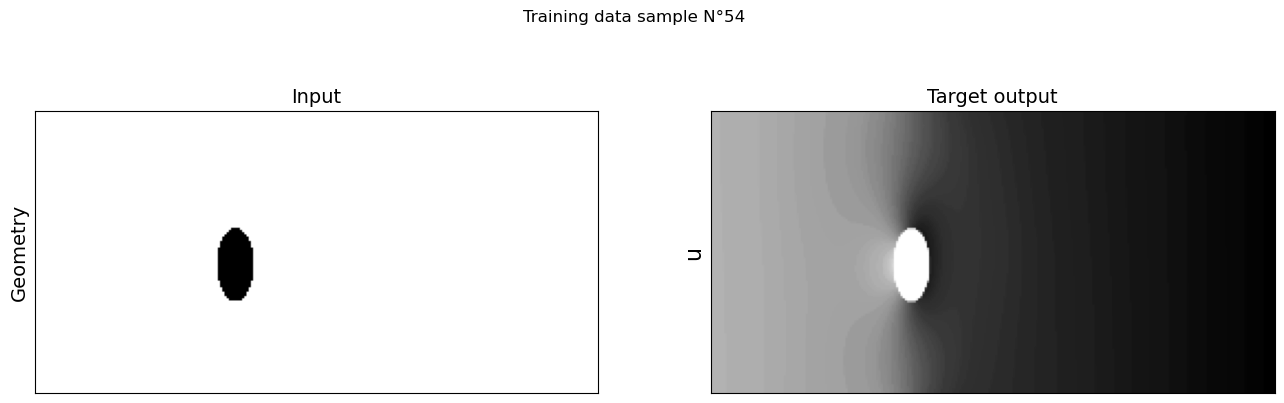

In [24]:
NUM=random.sample(range(1, geo_array_train.shape[0]), 1)
plot( geo_array_train[NUM[0]],p_array_train[NUM[0]], title=f"Training data sample N°{NUM[0]}") 

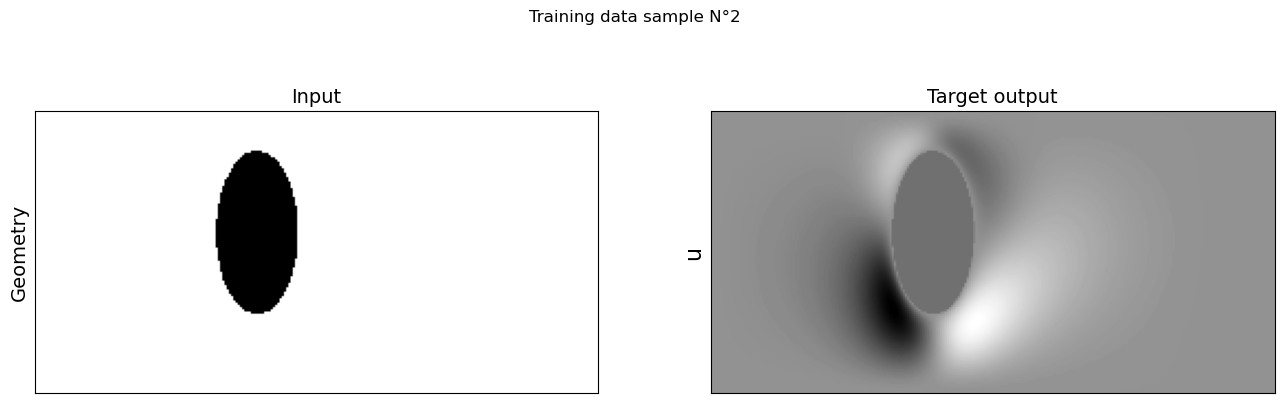

In [25]:
NUM=random.sample(range(1, geo_array_train.shape[0]), 1)
plot( geo_array_train[NUM[0]],vy_array_train[NUM[0]], title=f"Training data sample N°{NUM[0]}") 

### 7. Hiperparameters

In [9]:
num_classes =param.num_classes
num_epochs =param.num_epochs
batch_size=param.batch_size
patience=param.patience
LR=param.LR
print(f'Classes= {num_classes},\n Epochs = {num_epochs},\n batches = {batch_size},\n lr = {LR}')

Classes= 1,
 Epochs = 30,
 batches = 10,
 lr = 0.0001


### 6. Arquitecture

In [10]:
class U_Net:
    
    def __init__(self):
        
        self.num_classes   = num_classes
        self.epoch         = num_epochs 
        self.batch_size    = batch_size
        self.patience      = patience
        self.w             = w
        self.h             = h
        self.LR            = LR
        
        # Data  
        self.train_data     =geo_array_train
        self.val_data       =geo_array_valid
        self.train_data_sol =mag_array_train
        self.val_data_sol   =mag_array_valid

        self.test_data      =geo_array_tests
        self.test_data_sol  =mag_array_tests
        self.ch             =self.train_data.shape[3]
        
    # Encode block with batchnormalization 
    def encoder_block(self,num_filters,x):
         x = Conv2D(num_filters, (3, 3),padding="same")(x)
         x = BatchNormalization()(x)
         x = Activation("relu")(x) 
    
         x = Conv2D(num_filters, (3, 3), padding="same")(x)
         x = BatchNormalization()(x)
         skip = Activation("relu")(x) 
        
         pool=MaxPooling2D((2,2))(skip)
         return pool,skip


    # Decode block  
    def decoder_block(self,num_filters,x1,x2):
        
        x=Conv2DTranspose(num_filters,(2,2),strides=(2, 2),padding="same")(x1) # remark: if it's used padding=valid, apply copy and crop the skip features
        x=concatenate([x,x2])
        x=Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
        x=Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
        return x
        
    # U_NET built
    def build(self):

         image_input = Input((self.h, self.w, self.ch))
        
         #contracting Path
         pool1,skip1 = self.encoder_block(64,image_input)
         pool2,skip2 = self.encoder_block(128,pool1)
        
         pool3,skip3 = self.encoder_block(256,pool2)
         pool4,skip4 = self.encoder_block(512,pool3)
         
         # Bottleneck

         b = Conv2D(1024, (3,3), activation='relu', padding='same')(pool4)
         b = Conv2D(1024, (3,3), activation='relu', padding='same')(b)
         
         # Expansive Path 
         x5 = self.decoder_block(512,b, skip4) 
         x6 = self.decoder_block(256,x5, skip3) 
         
         x7 = self.decoder_block(128,x6, skip2) 
         x8 = self.decoder_block(64,x7, skip1) 
    
         # Output the last block
         output=Conv2D(self.num_classes, (1, 1), activation="relu", padding="same")(x8)  # one channel correspond to one class
         output = image_input * output
         # Define model
         model = models.Model(image_input, output, name="U-Net")
     
         return model 
       
    # Callback early stopping  
    # Early stops the training if validation loss doesn't improve after a given patience
    def early_stopping(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.patience, restore_best_weights=True)
        return early_stopping
        
    def parameters(self):
        model=self.build()
        return model.summary()
        
    # Compile and fit the model
    def execute(self):
        
            model=self.build()
            plot_model(model, to_file="//home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/Result_01/U_Net.png")
            checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/Result_01/Best_weights.weights.h5",save_weights_only=True)
            
            optimizer = tf.keras.optimizers.Adam(learning_rate=self.LR)  
            model.compile(optimizer="RMSProp",loss=["MSE"],metrics=["MAE"])
            # model.compile(optimizer=optimizer,loss=["MSE"],metrics=["MAE"])
        
            model.summary()
            
            model_fitted=model.fit(self.train_data,self.train_data_sol,
                                   batch_size=self.batch_size,
                                   validation_split = 0.2,
                                   # validation_data=(self.val_data, self.val_data_sol),
                                    epochs=self.epoch,callbacks=[self.early_stopping(),checkpoint_cb])
        
            callbacks = [tf.keras.callbacks.ModelCheckpoint("//home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/Result_01/Unet.keras",save_best_only=True)]
            model.save('//home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/Result_01/Completed_Model.h5')
            return model_fitted

### 7. Training the model

In [11]:
M=U_Net()
history=M.execute()

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step - MAE: 0.1184 - loss: 0.0290 - val_MAE: 0.1509 - val_loss: 0.0308
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - MAE: 0.0652 - loss: 0.0086 - val_MAE: 0.1501 - val_loss: 0.0305
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - MAE: 0.0615 - loss: 0.0080 - val_MAE: 0.1486 - val_loss: 0.0300
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - MAE: 0.0515 - loss: 0.0061 - val_MAE: 0.1416 - val_loss: 0.0278
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - MAE: 0.0389 - loss: 0.0049 - val_MAE: 0.1323 - val_loss: 0.0249
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - MAE: 0.0335 - loss: 0.0044 - val_MAE: 0.1257 - val_loss: 0.0230
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - MAE: 0.0343 - loss: 0.0046 - val_MAE: 0.1151 - val_loss: 0.0201
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - MAE: 0.0309 - loss: 0.004

In [14]:
def plot_results(history):
    epoch_count=range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(13,4), dpi=150)
    plt.subplot(121)
    plt.plot(epoch_count, history.history['loss'], 'b', label = 'training loss')
    plt.plot(epoch_count, history.history['val_loss'], 'r', label ='validation loss')
    plt.yscale('log')
    plt.legend()
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.subplot(122)
    plt.plot(epoch_count, history.history['MAE'], 'b', label ='training mae')
    plt.plot(epoch_count, history.history['val_MAE'], 'r', label ='validation mae')
    plt.yscale('log')
    plt.legend()
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.savefig('Loss_and_MAE.png')


### 8. Displaying training and validation loss curves

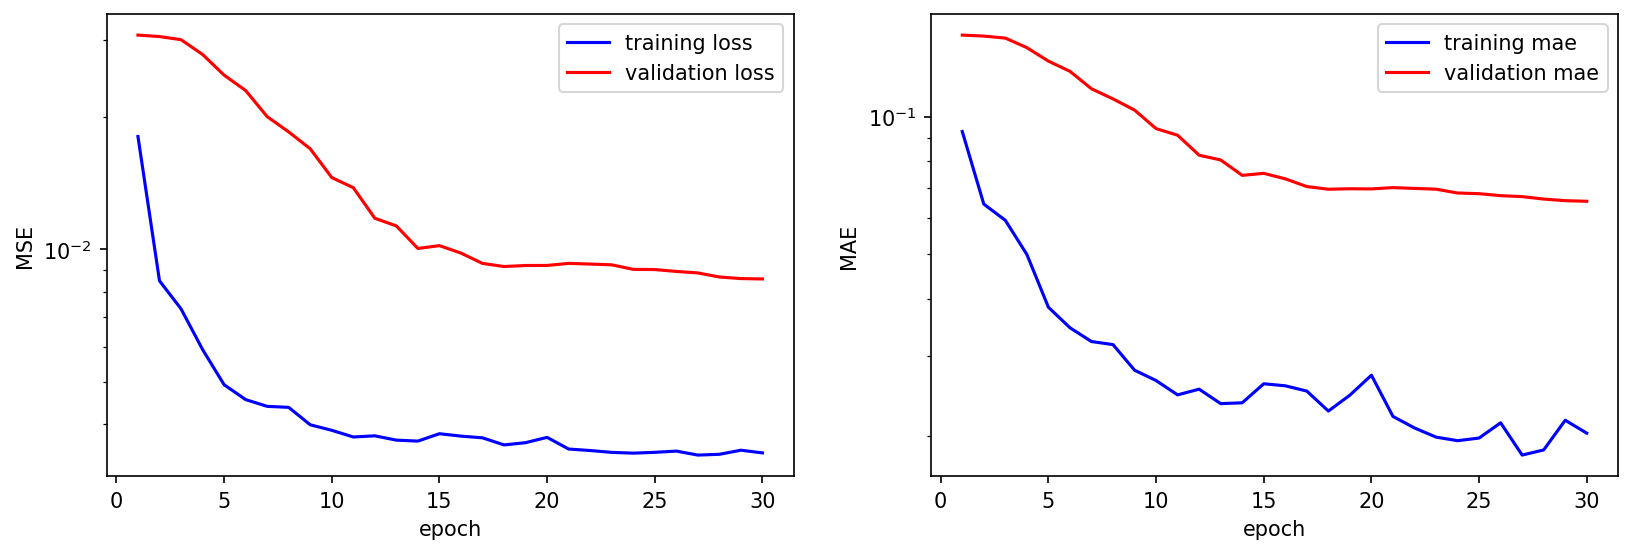

In [15]:
plot_results(history)

### 9. Predictions

In [16]:
path='/home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/Result_01/Best_weights.weights.h5'
M=U_Net()
model=M.build()
model.load_weights(path)
u_predictions=model.predict(geo_array_tests)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


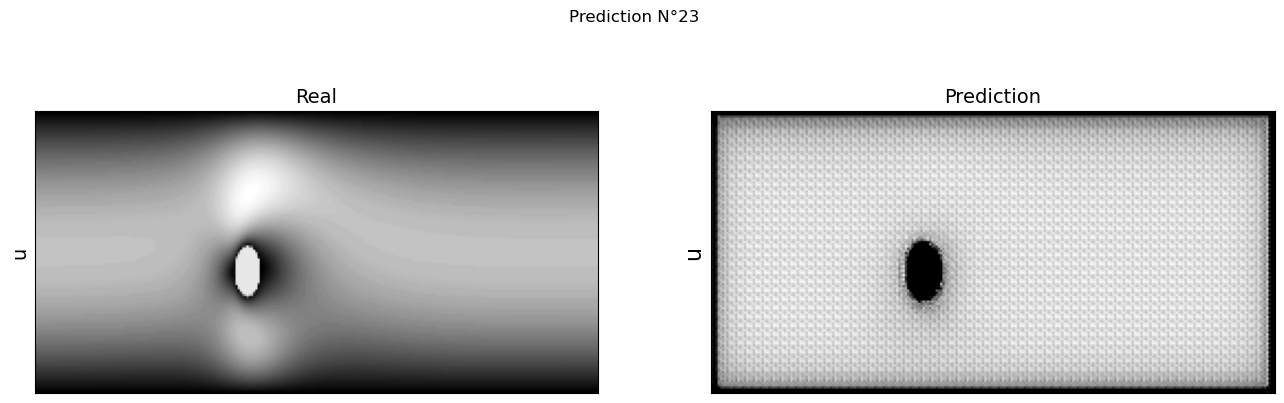

In [17]:
NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot( mag_array_tests[NUM[0]],u_predictions[NUM[0]], title=f"Prediction N°{NUM[0]}",opt='plot')

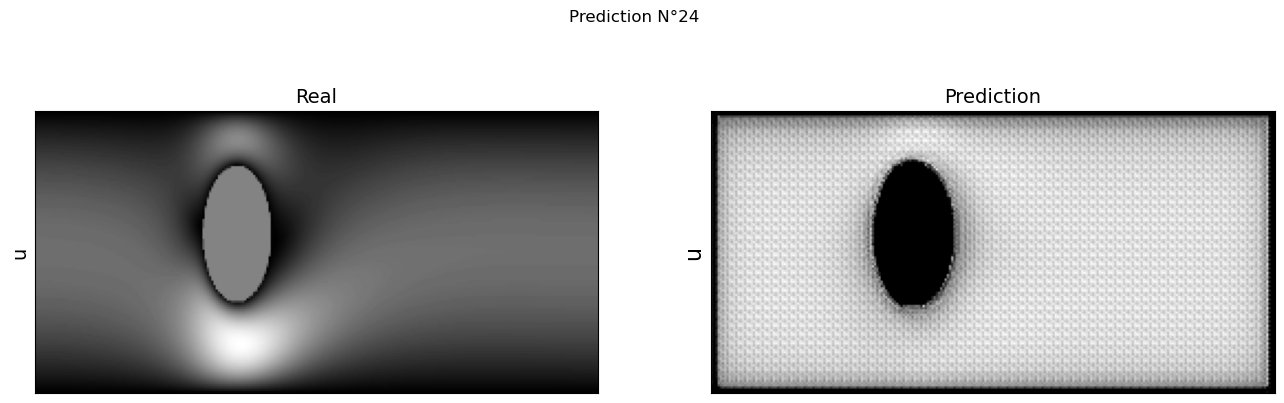

In [18]:
NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot( mag_array_tests[NUM[0]],u_predictions[NUM[0]], title=f"Prediction N°{NUM[0]}",opt='plot')